In [ ]:
import numpy as np
from numpy import unique, argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Conv1D, MaxPool1D
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt

import hashlib
import time

import random

In [ ]:
def read_items(data_file_name, label_file_name):
  with open(data_file_name) as f:
      lines = f.read().splitlines()
      data = np.empty([len(lines), 8, 8], dtype=np.uint32)
      for index, item in enumerate(lines):
          item = f'{item:064}'
          ephemeral_id = string_to_uint32_array(item)
          data[index] = ephemeral_id

  with open(label_file_name) as f:
      labels = f.read().splitlines()
  labels = [int(i) for i in labels]
  labels = np.asarray(labels)
  labels = labels.reshape(len(labels), 1)

  return data, labels

In [ ]:
def generate_ephemeral_id(seed):
    data = f"{seed}{time.time()}".encode('utf-8')
    hash_object = hashlib.sha256(data)
    ephemeral_id = hash_object.hexdigest()
    return ephemeral_id


def string_to_uint32_2d_array(id):
    flat_array = [int(id[i:i+1], 16) for i in range(0, len(id), 1)]
    array_2d = np.array(flat_array).reshape(8, 8)
    return array_2d


def string_to_uint32_1d_array(id):
    flat_array = [int(id[i:i+1], 16) for i in range(0, len(id), 1)]
    flat_array = np.array(flat_array).reshape(64,)
    return flat_array

In [ ]:
def generate_data(size: int, seeds):
  data = np.empty([size, 8, 8], dtype=np.uint32)
  labels = np.empty([size, 1], dtype=np.ubyte)

  for data_index in range(size):
    device_number = random.randint(0, len(seeds)-1)
    labels[data_index] = device_number
    ephemeral_id = generate_ephemeral_id(seeds[device_number])
    data[data_index] = string_to_uint32_2d_array(ephemeral_id)

  return (data, labels)

In [ ]:
def generate_data_1d(size: int, seeds):
  data = np.empty([size, 64], dtype=np.uint32)
  labels = np.empty([size, 1], dtype=np.ubyte)

  for data_index in range(size):
    device_number = random.randint(0, len(seeds)-1)
    labels[data_index] = device_number
    ephemeral_id = generate_ephemeral_id(seeds[device_number])
    data[data_index] = string_to_uint32_1d_array(ephemeral_id)

  return (data, labels)

In [ ]:
SEEDS = ["Device0", "Device1", "Device2", "Device3"]

NUM_TRAIN_DATA = 10000
NUM_VAL_DATA = 1000
NUM_TEST_DATA = 500

all_python = True

if all_python:
    training_data, training_labels = generate_data(NUM_TRAIN_DATA, SEEDS)
    validation_data, validation_labels = generate_data(NUM_VAL_DATA, SEEDS)
    test_data, test_labels = generate_data(NUM_TEST_DATA, SEEDS)
else:
    training_data, training_labels = read_items("training_data.txt", "training_labels.txt")
    validation_data, validation_labels = read_items("validation_data.txt", "validation_labels.txt")
    test_data, test_labels = read_items("test_data.txt", "test_labels.txt")

In [ ]:
is_2d = False

if is_2d:
    training_data = np.reshape(training_data, (training_data.shape[0], training_data.shape[1], training_data.shape[2], 1))
    validation_data = np.reshape(validation_data, (validation_data.shape[0], validation_data.shape[1], validation_data.shape[2], 1))
    test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))
else:
    training_data = np.reshape(training_data, (training_data.shape[0], training_data.shape[1] * training_data.shape[2]))
    validation_data = np.reshape(validation_data, (validation_data.shape[0], validation_data.shape[1] * validation_data.shape[2]))
    test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1] * test_data.shape[2],))

print("Size of training data is ", np.shape(training_data))
print("Size of validation data is ", np.shape(validation_data))
print("Size of test data is ", np.shape(test_data))

Size of training data is  (10000, 64)
Size of validation data is  (1000, 64)
Size of test data is  (500, 64)


In [ ]:
if is_2d:
    model = Sequential([
        Conv2D(6, (3, 3), activation='relu', input_shape=training_data.shape[1:]),
        MaxPool2D(2, 2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(len(SEEDS), activation='softmax')
    ])
else:
    model = Sequential([
        Dense(200, activation='relu', input_shape=training_data.shape[1:]),
        Dropout(.3),
        #Dense(20, activation='relu'),
        Dense(len(SEEDS), activation='softmax')
    ])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_2 = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels), batch_size=10, epochs=10)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 200)               13000     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_43 (Dense)            (None, 4)                 804       
                                                                 
Total params: 13804 (53.92 KB)
Trainable params: 13804 (53.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 4s 3ms/step - loss: 1.6795 - accuracy: 0.2422 - val_loss: 1.3905 - val_accuracy: 0.2580
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3900 - accuracy: 0.2552 - val_loss: 1.3856 - val_accuracy: 

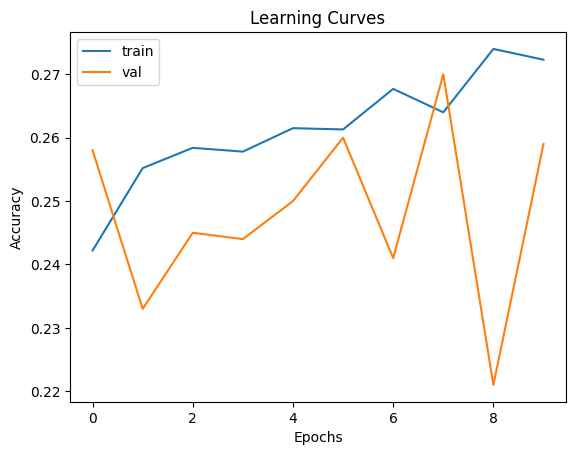

In [ ]:
# ploting the learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.plot(history_2.history['accuracy'], label='train')
pyplot.plot(history_2.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f'Accuracy: {accuracy*100}')

Accuracy: 28.999999165534973


In [ ]:
for index in range(len(test_data)):
  prediction = model.predict([np.expand_dims(test_data[index], axis=0)], verbose = 0)
  print('Predicted label: {} - Actual label: {}'.format(argmax(prediction), test_labels[index]))

Predicted label: 0 - Actual label: [0]
Predicted label: 1 - Actual label: [3]
Predicted label: 3 - Actual label: [1]
Predicted label: 1 - Actual label: [0]
Predicted label: 3 - Actual label: [1]
Predicted label: 1 - Actual label: [3]
Predicted label: 1 - Actual label: [1]
Predicted label: 3 - Actual label: [0]
Predicted label: 3 - Actual label: [3]
Predicted label: 1 - Actual label: [2]
Predicted label: 2 - Actual label: [1]
Predicted label: 0 - Actual label: [0]
Predicted label: 3 - Actual label: [1]
Predicted label: 0 - Actual label: [0]
Predicted label: 2 - Actual label: [0]
Predicted label: 2 - Actual label: [2]
Predicted label: 0 - Actual label: [1]
Predicted label: 2 - Actual label: [1]
Predicted label: 3 - Actual label: [0]
Predicted label: 1 - Actual label: [2]
Predicted label: 1 - Actual label: [0]
Predicted label: 2 - Actual label: [2]
Predicted label: 2 - Actual label: [0]
Predicted label: 3 - Actual label: [1]
Predicted label: 1 - Actual label: [3]
Predicted label: 3 - Actu

In [ ]:
pip install tinymlgen

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2225 sha256=cdf3b5e7a715ed55469228c54b2c3020dc0cb9bc2a55004a57a76b3a9ceb8c40
  Stored in directory: /root/.cache/pip/wheels/37/f6/60/b245c012a863872e10d737539c1e3f2db0499dfb6735f48494
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8894 sha256=ff5b71c561d48c6126c3719f80e9ce029abcafff4305e0d20d64e822a3eae171
  Stored in directory: /root/.cache/pip/wheels/26/28/f7/f47d7ecd9ae44c4457e72c8bb617ef18ab332ee2b2a1047e87
Successfully built tinymlgen hexdump


In [ ]:
from tinymlgen import port

c_code = port(model, variable_name='model', pretty_print=True,optimize=False)
filename = 'net.h'
with open(filename,'w') as f:
    f.write(c_code)

In [ ]:
test_data[0].flatten()

array([ 3, 11,  7, 13,  2,  7,  7,  8,  6, 15, 15, 15, 14, 12,  6,  2, 10,
       14,  5,  1,  2,  0, 11,  8,  8,  4,  1, 13, 15,  7,  5,  2,  1, 13,
       12,  9, 15,  6, 15, 11, 15,  0, 13, 12,  6, 10, 15,  2, 15,  5,  3,
        2, 13,  2, 10,  3, 11, 13,  9, 15,  3,  4,  8,  4], dtype=uint32)